In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from ramannoodles import spectrafit
from ramannoodles import shoyu
from scipy import interpolate
import pandas as pd

In [2]:
#If you re-call the method, it will tell you that the files are already downloaded.
shoyu.initialize_standard_library()
# open spectra library
shoyu_data_dict = pickle.load(open('../raman_spectra/shoyu_data_dict.p', 'rb'))
# list keys
sorted(shoyu_data_dict.keys())

file already in raman_spectra folder
WATER loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
CARBON MONOXIDE loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
CARBON DIOXIDE loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
FORMIC ACID loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
2-PROPANOL loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
ETHYL ALCOHOL loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
DIMETHYL KETONE loaded into the dictionary - shoyu_data_dict.p


['2-PROPANOL',
 'CARBON DIOXIDE',
 'CARBON MONOXIDE',
 'DIMETHYL KETONE',
 'ETHYL ALCOHOL',
 'FORMIC ACID',
 'WATER']

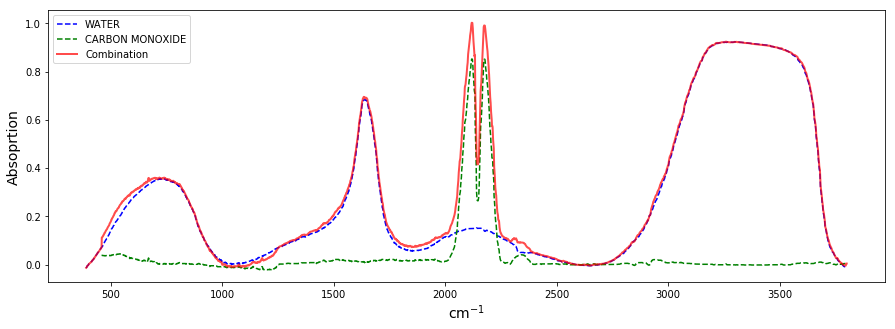

In [3]:
compound_1 = shoyu_data_dict['WATER']
compound_2 = shoyu_data_dict['CARBON MONOXIDE']
spectra_x, spectra_y = shoyu.combine_spectra(compound_1, compound_2, plot = True)

In [4]:
# Exploring a basic example from lmfit documentation
import lmfit
import numpy as np
x = np.linspace(0.3, 10, 100)
np.random.seed(0)
y = 1/(0.1*x) + 2 + 0.1*np.random.randn(x.size)
pars = lmfit.Parameters()
pars.add_many(('a', 0.1), ('b', 1))
def residual(p):
    return 1/(p['a']*x) + p['b'] - y

In [5]:
# Running a fit 
mini = lmfit.Minimizer(residual,pars)
result = mini.minimize()
print(mini.leastsq())
print(lmfit.fit_report(result.params))

[[Variables]]
    a:  0.09943896 +/- 1.9322e-04 (0.19%) (init = 0.1)
    b:  1.98476945 +/- 0.01222678 (0.62%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) =  0.601


In [6]:
# Getting a basic confidence interval
ci = lmfit.conf_interval(mini,result)
lmfit.printfuncs.report_ci(ci)

      99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a:  -0.00059  -0.00039  -0.00019   0.09944  +0.00019  +0.00039  +0.00060
 b:  -0.03766  -0.02478  -0.01230   1.98477  +0.01230  +0.02478  +0.03761


In [7]:
# using quantiles got the sigmas and using the trace

In [ ]:
#Bootstrapping is also an option

Now we look at a problem where calculating the error from approximated covariance can lead to misleading result – two decaying exponentials. In fact such a problem is particularly hard for the Levenberg-Marquardt method, so we first estimate the results using the slower but robust Nelder-Mead method, and then use Levenberg-Marquardt to estimate the uncertainties and correlations.

In [10]:
import math
compound_1 = shoyu_data_dict['WATER']
x_water = compound_1['x']
y_water = compound_1['y']
compound_2 = shoyu_data_dict['CARBON MONOXIDE']
x_co = compound_1['x']
y_co = compound_1['y']
data_peaks_centers1 = spectrafit.compound_report(compound_1)
print(data_peaks_centers1)
data_peaks_centers2 = spectrafit.compound_report(compound_2) 
print(data_peaks_centers2)
compound_1 = shoyu_data_dict['WATER']
compound_2 = shoyu_data_dict['CARBON MONOXIDE']
spectra_x, spectra_y = shoyu.combine_spectra(compound_1, compound_2, plot = False)
data_peaks_spectra= spectrafit.data_report(spectra_x, spectra_y)
print(data_peaks_spectra)
#function calculates distance start
def peak_1D_distancescore(rowA,rowB):
    scores = []
    #calculate distance
    #√((x1-x2)^2 + (y1-y2)^2)
    for i in range(len(rowA)):
        for j in range(len(rowB)):
            distance = sum([math.pow(rowA[i] - rowB[j], 2)])
            distance = math.sqrt(distance)
            if (1/(distance + 1)>.05):
                scores.append(((rowA[i],rowB[j]),(1/(distance + 1))))
    print(scores)
    return scores
def peak_2D_distancescore(rowA,rowB,rowC,rowD):
    scores = []
    #calculate distance
    #√((x1-x2)^2 + (y1-y2)^2)
    for i in range(len(rowA)):
        for j in range(len(rowB)):
            distance = sum([math.pow(rowA[i] - rowB[j], 2)]+[math.pow(rowC[i] - rowD[j], 2)])
            distance = math.sqrt(distance)
            if (1/(distance + 1)>.05):
                scores.append(((rowA[i],rowB[j],rowC[i],rowD[j]),(1/(distance + 1))))
    print(scores)
    return scores
def distance_sort(array_input, row):
    """
    Returns list of sorted Euclidean distances between
    the input data and all rows in the dataframe.

    Parameters:
        df_input (Dataframe): Dataframe input
        row (list): input list

    Returns:
        sorteddistances (list): sorted Euclidean distances
    """
    sorteddistances = np.full(len(array_input), np.nan)  
    for index_i in range(len(array_input)):
        sorteddistances[index_i]=peak_1D_distancescore(row, array_input[index_i])
        #print(sorteddistances)
    sorteddistances.sort()
    return sorteddistances

[711.4826030832157, 1638.6886199554203, 3312.1231809302135]
[2109.8548231081886, 2183.58416497579]
[708.0, 1638.5198632531205, 2110.0000000000095, 2184.149153919652, 3268.999999970273]


In [11]:
sorteddistances=[]
sorteddistances.append(peak_1D_distancescore(data_peaks_spectra,data_peaks_centers1))
sorteddistances.append(peak_1D_distancescore(data_peaks_spectra,data_peaks_centers2))
sorted(sorteddistances)

[((708.0, 711.4826030832157), 0.22308466340558056), ((1638.5198632531205, 1638.6886199554203), 0.8556100666907647)]
[((2110.0000000000095, 2109.8548231081886), 0.8732275399042558), ((2184.149153919652, 2183.58416497579), 0.6389821499520236)]


[[((708.0, 711.4826030832157), 0.22308466340558056),
  ((1638.5198632531205, 1638.6886199554203), 0.8556100666907647)],
 [((2110.0000000000095, 2109.8548231081886), 0.8732275399042558),
  ((2184.149153919652, 2183.58416497579), 0.6389821499520236)]]

[620.6820993063426, 652.1156598823245, 680.3282599999995, 723.8750859253754, 2304.1651179999994, 2336.8755009789434, 3590.9856357827366, 3621.8934979836718, 3692.2514877580816, 3720.4308850577695]
<class 'list'>
[2109.8548231081886, 2183.58416497579]
<class 'list'>
[621.0442289082655, 651.8072355339556, 679.9999999999992, 724.52234753581, 2112.000000000002, 2182.7770407196494, 2308.7085930807248, 2338.999999970375, 3591.1759676550155, 3622.0652181439837, 3692.2127027246315, 3720.6376840597777]
<class 'list'>
[((708.0, 711.4826030832157), 0.22308466340558056), ((1638.5198632531205, 1638.6886199554203), 0.8556100666907647)]
[((2110.0000000000095, 2109.8548231081886), 0.8732275399042558), ((2184.149153919652, 2183.58416497579), 0.6389821499520236)]
[((621.0442289082655, 620.6820993063426), 0.7341445326408823), ((651.8072355339556, 652.1156598823245), 0.7642780427057861), ((679.9999999999992, 680.3282599999995), 0.7528646499930308), ((724.52234753581, 723.8750859253754), 0.6070681145395971

[([((621.0442289082655, 620.6820993063426), 0.7341445326408823),
   ((651.8072355339556, 652.1156598823245), 0.7642780427057861),
   ((679.9999999999992, 680.3282599999995), 0.7528646499930308),
   ((724.52234753581, 723.8750859253754), 0.6070681145395971),
   ((2308.7085930807248, 2304.1651179999994), 0.1803922603489283),
   ((2338.999999970375, 2336.8755009789434), 0.3200513115037985),
   ((3591.1759676550155, 3590.9856357827366), 0.8401018432662083),
   ((3622.0652181439837, 3621.8934979836718), 0.8534460990530406),
   ((3692.2127027246315, 3692.2514877580816), 0.9626630802320802),
   ((3720.6376840597777, 3720.4308850577695), 0.828638404851114)],
  'CO2compCO'),
 ([((708.0, 711.4826030832157), 0.22308466340558056),
   ((1638.5198632531205, 1638.6886199554203), 0.8556100666907647)],
  'H2OcompCO'),
 ([((2110.0000000000095, 2109.8548231081886), 0.8732275399042558),
   ((2184.149153919652, 2183.58416497579), 0.6389821499520236)],
  'COcompH2O'),
 ([((2112.000000000002, 2109.8548231081

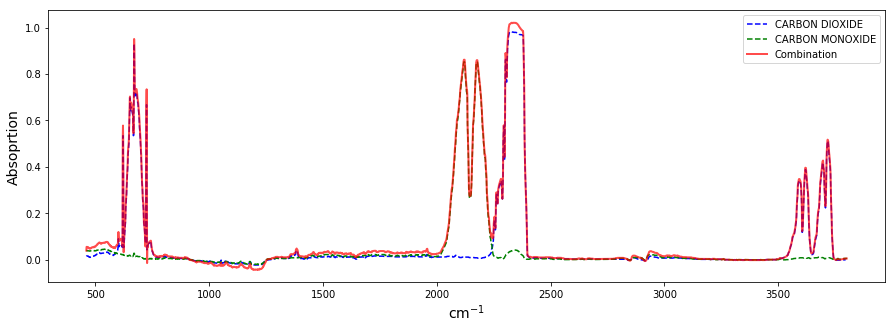

In [12]:
compound_1 = shoyu_data_dict['CARBON DIOXIDE']
compound_2 = shoyu_data_dict['CARBON MONOXIDE']
data_peaks1 = spectrafit.compound_report(compound_1)
print(data_peaks1)
print(type(data_peaks1))
data_peaks2 = spectrafit.compound_report(compound_2)
print(data_peaks2)
print(type(data_peaks2))
combined_x,combined_y = shoyu.combine_spectra(compound_1,compound_2, plot = True)
data_peaks_combine = spectrafit.data_report(combined_x, combined_y)
print(data_peaks_combine)
print(type(data_peaks_combine ))
sorteddistances=[]
sorteddistances.append((peak_1D_distancescore(data_peaks_spectra,data_peaks_centers1),'H2OcompCO'))
sorteddistances.append((peak_1D_distancescore(data_peaks_spectra,data_peaks_centers2),'COcompH2O'))
sorteddistances.append((peak_1D_distancescore(data_peaks_combine,data_peaks1),'CO2compCO'))
sorteddistances.append((peak_1D_distancescore(data_peaks_combine,data_peaks2,),'COcompCO2'))
sorted(sorteddistances)